In [20]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F

from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

torch.set_printoptions(linewidth=160)


def display_img_tensors_as_grid(img_tensors, nrows, f):
    img_tensors = img_tensors.permute(0, 2, 3, 1)
    imgs_array = img_tensors.detach().cpu().numpy()
    imgs_array[imgs_array < -0.5] = -0.5
    imgs_array[imgs_array > 0.5] = 0.5
    imgs_array = 255 * (imgs_array + 0.5)
    (batch_size, img_size) = img_tensors.shape[:2]
    ncols = batch_size // nrows
    img_arr = np.zeros((nrows * batch_size, ncols * batch_size, 3))
    for idx in range(batch_size):
        row_idx = idx // ncols
        col_idx = idx % ncols
        row_start = row_idx * img_size
        row_end = row_start + img_size
        col_start = col_idx * img_size
        col_end = col_start + img_size
        img_arr[row_start:row_end, col_start:col_end] = imgs_array[idx]

    display(Image.fromarray(img_arr.astype(np.uint8), "RGB"))

In [21]:
class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        layers = []
        for i in range(num_residual_layers):
            layers.append(
                nn.Sequential(
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_hiddens,
                        out_channels=num_residual_hiddens,
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_residual_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=1,
                    ),
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        h = x
        for layer in self.layers:
            h = h + layer(h)

        # ResNet V1-style.
        return torch.relu(h)

In [22]:
class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        # The last ReLU from the Sonnet example is omitted because ResidualStack starts
        # off with a ReLU.
        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0:
                out_channels = num_hiddens // 2
            elif downsampling_layer == 1:
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)

            else:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        conv.add_module(
            "final_conv",
            nn.Conv2d(
                in_channels=num_hiddens,
                out_channels=num_hiddens,
                kernel_size=3,
                padding=1,
            ),
        )
        self.conv = conv
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )

    def forward(self, x):
        h = self.conv(x)
        return self.residual_stack(h)

Encoder는 input image x에 convolutional layer를 적용하여 (3, 32, 32) -> (64, 16, 16) -> (128, 8, 8)로 변환한다. 본 논문에서는 input $x$에 대해 $z_e(x)$를 반환하는 역할을 한다.

In [23]:
class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_hiddens,
        num_upsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        self.conv = nn.Conv2d(
            in_channels=embedding_dim,
            out_channels=num_hiddens,
            kernel_size=3,
            padding=1,
        )
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )
        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):
            if upsampling_layer < num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            elif upsampling_layer == num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)

            else:
                (in_channels, out_channels) = (num_hiddens // 2, 3)

            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        h = self.residual_stack(h)
        x_recon = self.upconv(h)
        return x_recon

Decoder는 Encoder와 반대로, latent variable x에 convolutional layer를 적용하여 (64, 8, 8) -> (128, 8, 8) -> (64, 16, 16) -> (3, 32, 32)로 변환한다. 즉, $z_q(x)$를 이용하여 원본 이미지를 복원하는 것이다.

In [24]:
class SonnetExponentialMovingAverage(nn.Module):
    # See: https://github.com/deepmind/sonnet/blob/5cbfdc356962d9b6198d5b63f0826a80acfdf35b/sonnet/src/moving_averages.py#L25.
    # They do *not* use the exponential moving average updates described in Appendix A.1
    # of "Neural Discrete Representation Learning".
    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay ** self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average

In [25]:
class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
        # See Section 3 of "Neural Discrete Representation Learning" and:
        # https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L142.

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        # Weight for the exponential moving average.
        self.decay = decay
        # Small constant to avoid numerical instability in embedding updates.
        self.epsilon = epsilon

        # Dictionary embeddings.
        limit = 3 ** 0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_(
            -limit, limit
        )
        if use_ema:
            self.register_buffer("e_i_ts", e_i_ts)
        else:
            self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        # Exponential moving average of the cluster counts.
        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        # Exponential moving average of the embeddings.
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)
        distances = (
            (flat_x ** 2).sum(1, keepdim=True)
            - 2 * flat_x @ self.e_i_ts
            + (self.e_i_ts ** 2).sum(0, keepdim=True)
        )
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(
            encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)
        ).permute(0, 3, 1, 2)

        # See second term of Equation (3).
        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        # See third term of Equation (3).
        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # Straight-through gradient. See Section 3.2.
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                # See Appendix A.1 of "Neural Discrete Representation Learning".

                # Cluster counts.
                encoding_one_hots = F.one_hot(
                    encoding_indices, self.num_embeddings
                ).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Updated exponential moving average of the cluster counts.
                # See Equation (6).
                self.N_i_ts(n_i_ts)

                # Exponential moving average of the embeddings. See Equation (7).
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                # This is kind of weird.
                # Compare: https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L270
                # and Equation (8).
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = (
                    (self.N_i_ts.average + self.epsilon)
                    / (N_i_ts_sum + self.num_embeddings * self.epsilon)
                    * N_i_ts_sum
                )
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (
            quantized_x,
            dictionary_loss,
            commitment_loss,
            encoding_indices.view(x.shape[0], -1),
        )

코드에서 e_i_ts, N_i_ts, m_i_ts는 각각 논문 Appendix A.1의 $e_i^{(t)}$, $N_i^{(t)}$, $m_i^{(t)}$를 뜻한다.

VectorQuantizer는 $z_e(x)$를 input x로 받고, 일련의 과정을 거쳐 quantized_x $v_q(x)$, dictionary_loss, commitment_loss의 값을 계산하여 반환한다. 이때 use_ema==True인 경우, 즉 EMA를 사용하는 경우 commitment_loss는 따로 계산하지 않는다. dictionary_loss와 commitment_loss의 식은 각각 다음과 같다.

$$ \Vert sg[z_e(x)]-e \Vert_2^2, \quad \Vert z_e(x)-sg[e] \Vert_2^2$$

In [26]:
class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        embedding_dim,
        num_embeddings,
        use_ema,
        decay,
        epsilon,
    ):
        super().__init__()
        self.encoder = Encoder(
            in_channels,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, _) = self.quantize(x)
        x_recon = self.decoder(z_quantized)
        return {
            "dictionary_loss": dictionary_loss,
            "commitment_loss": commitment_loss,
            "x_recon": x_recon,
        }

VQVAE는 위에서 정의한 Encoder, VectorQuantizer와 Decoder를 합쳐놓은 모델로, input image x에 대해 dictionary_loss, commitment_loss와 복원 이미지 x_recon을 반환한다.

In [27]:
# Initialize model.
device = torch.device("cuda:0")
use_ema = True
model_args = {
    "in_channels": 3,
    "num_hiddens": 128,
    "num_downsampling_layers": 2,
    "num_residual_layers": 2,
    "num_residual_hiddens": 32,
    "embedding_dim": 64,
    "num_embeddings": 512,
    "use_ema": use_ema,
    "decay": 0.99,
    "epsilon": 1e-5,
}
model = VQVAE(**model_args).to(device)

# Initialize dataset.
batch_size = 32
workers = 10
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[1.0, 1.0, 1.0])
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        normalize,
    ]
)
data_root = "data"
train_dataset = CIFAR10(data_root, True, transform, download=True)
train_data_variance = np.var(train_dataset.data / 255)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
)

# Multiplier for commitment loss. See Equation (3) in "Neural Discrete Representation
# Learning".
beta = 0.25

# Initialize optimizer.
train_params = [params for params in model.parameters()]
lr = 3e-4
optimizer = optim.Adam(train_params, lr=lr)
criterion = nn.MSELoss()

# Train model.
epochs = 7
eval_every = 100
best_train_loss = float("inf")
model.train()

Files already downloaded and verified


VQVAE(
  (encoder): Encoder(
    (conv): Sequential(
      (down0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (relu0): ReLU()
      (down1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (relu1): ReLU()
      (final_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (residual_stack): ResidualStack(
      (layers): ModuleList(
        (0): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
  )
  (pre_vq_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (vq): VectorQuantizer(
    (N_i_ts): Son

In [28]:
for epoch in range(epochs):
    total_train_loss = 0
    total_recon_error = 0
    n_train = 0
    for (batch_idx, train_tensors) in enumerate(train_loader):
        optimizer.zero_grad()
        imgs = train_tensors[0].to(device)
        out = model(imgs)
        recon_error = criterion(out["x_recon"], imgs) / train_data_variance
        total_recon_error += recon_error.item()
        loss = recon_error + beta * out["commitment_loss"]
        if not use_ema:
            loss += out["dictionary_loss"]

        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        n_train += 1

        if ((batch_idx + 1) % eval_every) == 0:
            print(f"epoch: {epoch}\nbatch_idx: {batch_idx + 1}", flush=True)
            total_train_loss /= n_train
            if total_train_loss < best_train_loss:
                best_train_loss = total_train_loss

            print(f"total_train_loss: {total_train_loss}")
            print(f"best_train_loss: {best_train_loss}")
            print(f"recon_error: {total_recon_error / n_train}\n")

            total_train_loss = 0
            total_recon_error = 0
            n_train = 0

epoch: 0
batch_idx: 100
total_train_loss: 0.6441174519062042
best_train_loss: 0.6441174519062042
recon_error: 0.6052357283234596

epoch: 0
batch_idx: 200
total_train_loss: 0.28206824481487275
best_train_loss: 0.28206824481487275
recon_error: 0.2572802722454071

epoch: 0
batch_idx: 300
total_train_loss: 0.22417123049497603
best_train_loss: 0.22417123049497603
recon_error: 0.19925670549273491

epoch: 0
batch_idx: 400
total_train_loss: 0.20188444182276727
best_train_loss: 0.20188444182276727
recon_error: 0.17755629748106003

epoch: 0
batch_idx: 500
total_train_loss: 0.18203495994210242
best_train_loss: 0.18203495994210242
recon_error: 0.15858893647789954

epoch: 0
batch_idx: 600
total_train_loss: 0.1667923027276993
best_train_loss: 0.1667923027276993
recon_error: 0.14207603938877583

epoch: 0
batch_idx: 700
total_train_loss: 0.1581755192577839
best_train_loss: 0.1581755192577839
recon_error: 0.13148619391024113

epoch: 0
batch_idx: 800
total_train_loss: 0.15172102853655814
best_train_loss

recon_error는 $\log p(x|z_q(x))$에 해당한다. 따라서 EMA를 사용하는 경우 loss의 식은 다음과 같다.

$$\log p(x|z_q(x))+\beta \Vert z_e(x)-sg[e] \Vert_2^2$$

이러한 학습 과정을 통해 얻은 모델로 test image를 복원한 결과는 다음과 같다.

Files already downloaded and verified


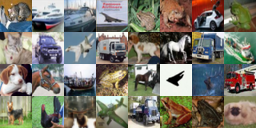

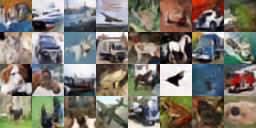

In [29]:
# Generate and show reconstructions.
model.eval()

valid_dataset = CIFAR10(data_root, False, transform, download=True)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    num_workers=workers,
)

with torch.no_grad():
    for valid_tensors in valid_loader:
        break

    display_img_tensors_as_grid(valid_tensors[0], 4, "true")
    display_img_tensors_as_grid(model(valid_tensors[0].to(device))["x_recon"], 4, "recon")